## Overview
This notebook builds on the previous [Heat Equation](HeatEquationHessian.ipynb) notebook.  Here though, we will regularize the inverse problem and solve for the initial temperature.

In this example, we will again be using the `HeatEquation1d` class, which has functions `Jacobian`, `Solve`, and `NodeLocations`.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import sklearn.linear_model as sklm 
import scipy.sparse as sp
import scipy.optimize as sopt

import sys
sys.path.append("../CommonTools")

from HeatEquation import HeatEquation1d


## Set up the heat equation solver

In [2]:
Nx = 100
dt = 1e-4
endTime = 0.02

heat = HeatEquation1d(Nx, dt)
nodeLocs = heat.NodeLocations()

stepLeft = 0.4
stepRight = 0.6
u0 = np.zeros((Nx,))
u0[(nodeLocs>=stepLeft)&(nodeLocs<=stepRight)] = 1.0

u = heat.Solve(u0, endTime)



## Extract the data and define the linear model

In [3]:
data = u[:,-1]


noiseStd = 1e-3
noiseVar = noiseStd**2

V = heat.Jacobian(endTime)

## L2 regularization
Objectives
- Understand the impact of the regularization strength
- Provide a comparison with L1 regularization

In [59]:
l2Strength = 100.0

L2_prob = sklm.Ridge(alpha=l2Strength,fit_intercept = False)
L2_prob.fit(V/noiseStd, data/noiseStd);

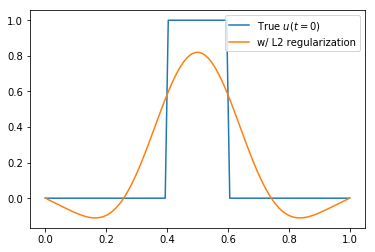

In [60]:
plt.plot(nodeLocs,u0,label='True $u(t=0)$');
plt.plot(nodeLocs, L2_prob.coef_, label='w/ L2 regularization');
plt.legend();

## L1 Regularization

In [65]:
l1Strength = 1.0

L1_prob = sklm.Lasso(alpha=l1Strength,fit_intercept = False)
L1_prob.fit(V/noiseStd, data/noiseStd);

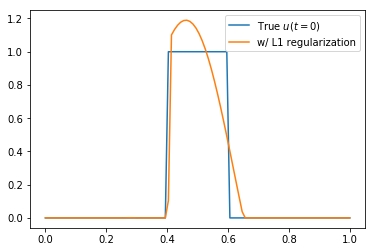

In [66]:
plt.plot(nodeLocs,u0,label='True $u(t=0)$');
plt.plot(nodeLocs, L1_prob.coef_, label='w/ L1 regularization');
plt.legend();

## Edge Regularization
$$
c(m) = \frac{1}{2}\|Vm-d\|^2_2 + \frac{\alpha_1}{2}\|m \|^2_2 + \alpha_2 \| Dm \|_1
$$


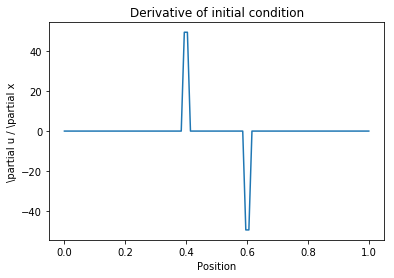

In [80]:
dx = nodeLocs[1] - nodeLocs[0]
D = sp.diags(( (0.5/dx)*np.ones(Nx-1), (-0.5/dx)*np.ones(Nx-1) ), offsets=[1,-1])

plt.plot(nodeLocs, D.dot(u0))
plt.xlabel('Position')
plt.ylabel('\partial u / \partial x')
plt.title('Derivative of initial condition');

In [81]:
regStrength1 = 10.0
regStrength2 = 1.0

def obj(m):
    return 0.5*(V@m - data).dot(V@m-data)/noiseVar + 0.5*regStrength1*m.dot(m) + regStrength2 * np.sum(np.abs(D.dot(m)))
def grad(m):
    return (V@m-data).T @ V / noiseVar + regStrength1*m + regStrength2 * D.T.dot(np.sign(D.dot(m))).T

m0 = np.zeros((Nx,))
res = sopt.minimize(obj,               # Objective function
                    L2_prob.coef_,     # Initial guess
                    jac=grad,          # Gradient function
                    method='L-BFGS-B', # Method
                    tol=1e-12, options={'maxiter':100000,'ftol':0})


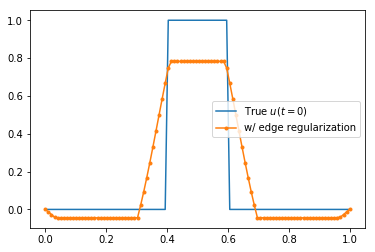

In [79]:
plt.plot(nodeLocs,u0,label='True $u(t=0)$');
plt.plot(nodeLocs, res['x'], '.-',label='w/ edge regularization');
plt.legend();